In [ ]:
#!pip install PyYAML

In [1]:
import cv2
import numpy as np
import os
import yaml
from yaml.loader import SafeLoader

In [2]:
# load YAML
with open('data (1).yaml',mode='r') as f:
    data_yaml = yaml.load(f,Loader=SafeLoader)
    
labels = data_yaml['names']
print(labels)

['Apple', 'Chapathi', 'Chicken Gravy', 'Fries', 'Idli', 'Pizza', 'Rice', 'Soda', 'Tomato', 'Vada', 'banana', 'burger']


In [24]:
# load YOLO model
yolo = cv2.dnn.readNetFromONNX('food_model9-20250514T063250Z-1-001/food_model9/weights/best.onnx')
yolo.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
yolo.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

In [25]:
# load the image
img = cv2.imread(r"C:\Users\ASUS\Downloads\archive\train\images\Burger-2_jpg.rf.21bbc5e855482e5747a586ed6a2eda68.jpg")
image = img.copy()
row, col, d = image.shape


# get the YOLO prediction from the the image
# step-1 convert image into square image (array)
max_rc = max(row,col)
input_image = np.zeros((max_rc,max_rc,3),dtype=np.uint8)
input_image[0:row,0:col] = image
# step-2: get prediction from square array
INPUT_WH_YOLO = 640
blob = cv2.dnn.blobFromImage(input_image,1/255,(INPUT_WH_YOLO,INPUT_WH_YOLO),swapRB=True,crop=False)
yolo.setInput(blob)
preds = yolo.forward() # detection or prediction from YOLO


In [26]:
print(preds.shape)

(1, 25200, 17)


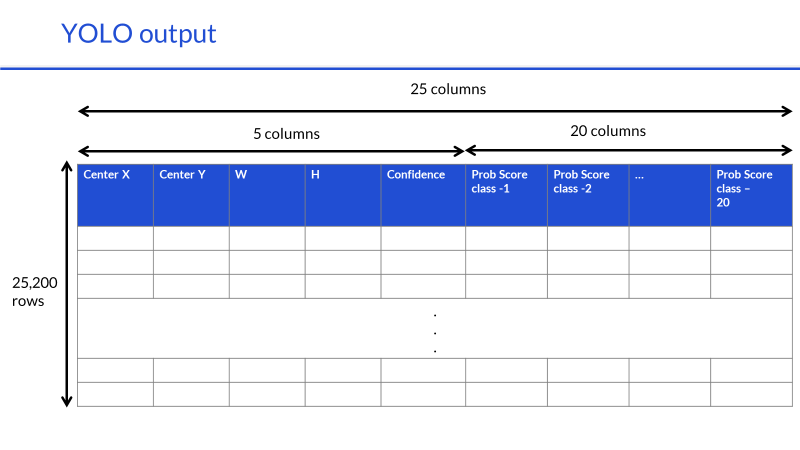

In [27]:
# Non Maximum Suppression
# Step-1: Filter detection based on confidence (0.4) and probability score (0.25)
detections = preds[0]
boxes = []
confidences = []
classes = []

# Width and height of the image (input_image)
image_h, image_w = input_image.shape[:2]
x_factor = image_w / INPUT_WH_YOLO
y_factor = image_h / INPUT_WH_YOLO

for i in range(len(detections)):
    row = detections[i]
    confidence = row[4]  # confidence of detecting an object
    if confidence > 0.4:
        class_score = row[5:].max()  # maximum probability from object classes
        class_id = row[5:].argmax()  # index position of the max probability

        if class_score > 0.25:
            cx, cy, w, h = row[0:4]

            # Convert to top-left x, y, width, height
            left = int((cx - 0.5 * w) * x_factor)
            top = int((cy - 0.5 * h) * y_factor)
            width = int(w * x_factor)
            height = int(h * y_factor)

            box = [left, top, width, height]

            # Append to lists
            boxes.append(box)
            confidences.append(float(confidence))
            classes.append(class_id)

# NMS
indices = cv2.dnn.NMSBoxes(boxes, confidences, 0.4, 0.45)

if len(indices) > 0:
    indices = np.array(indices).flatten()
    for i in indices:
        final_box = boxes[i]
        final_class = classes[i]
        final_conf = confidences[i]
        # You can draw the box here or process it further
else:
    indices = []  # no valid detections


In [28]:
indices

array([2], dtype=int32)

In [29]:
# Draw the Bounding Boxes
for ind in indices:
    x, y, w, h = boxes[ind]
    bb_conf = int(confidences[ind] * 100)
    class_id = classes[ind]
    class_name = labels[class_id]

    text = f'{class_name}: {bb_conf}%'

    cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.rectangle(image, (x, y - 30), (x + w, y), (255, 255, 255), -1)

    cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_PLAIN, 0.7, (0, 0, 0), 1)


In [30]:
cv2.imshow('original',img)
cv2.imshow('yolo_prediction',image)
cv2.waitKey(0)
cv2.destroyAllWindows()

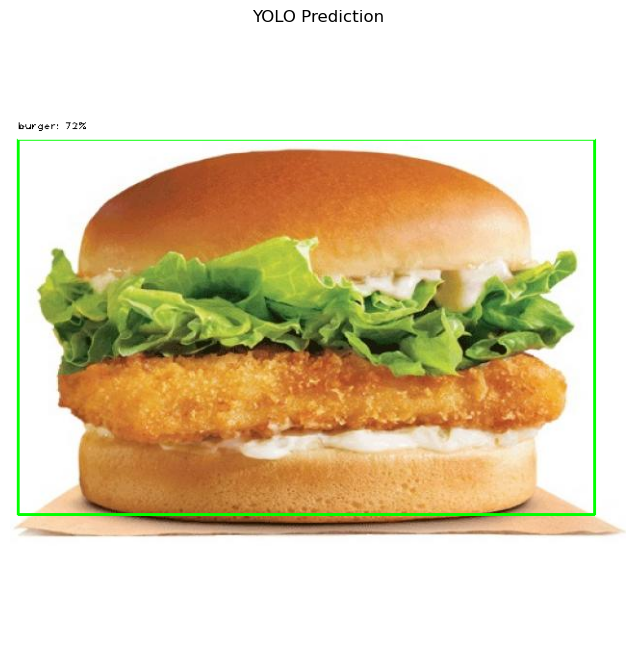

In [31]:
from matplotlib import pyplot as plt

# Convert BGR to RGB for correct colors in matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('YOLO Prediction')
plt.axis('off')
plt.show()
